# Coursework 3 - Mathematical Methods for Bioengineers

**Author**: Jorge Bennasar Vázquez | **CID**: 01809233

<div style="text-align: justify"> In this coursework, the analysed data consists of the recorded fluorescence time series (obtained by calcium imaging) of 75 pyramidal neurons in the hippocampal region CA1 while a mouse was moving around a circular track, the corresponding angular position of the mouse in degrees, and the frequency of recording. The study was centred in two main topics. Firstly, in section 1, a spike detection algorithm was implemented. Later, from sections 2 to 5, and using the results from section 1, the relation between the angular position of the mouse and the firing of its neurons was studied with different approaches. </div>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import scipy as sc
import scipy.io as sio
import seaborn as sns
import math as mh
import sklearn.feature_selection as sklfs

In [3]:
# Load data:

mat_contents_1 = sio.loadmat('cw1_data1.mat')
fs = mat_contents_1['fs'].flatten()[0]
mouse_theta = mat_contents_1['mouse_theta']

mat_contents_2 = sio.loadmat('cw1_data2.mat')
dFonF = mat_contents_2['dFonF']

L = np.size(dFonF[0],0)
t_im = np.linspace(0,L*1/fs,L)
N = 75

## Section 1

<div style="text-align: justify"> First of all, it is important to note that the noise in the fluorescence signals could pervert the results. This is why the data is filtered. For that, a highpass Butterworth filter of order 5 and cutoff frequency of 0.5 Hz was applied to the signals to detect the noise, and later this noise was subtracted to the original time series to obtain the filtered data. </div>

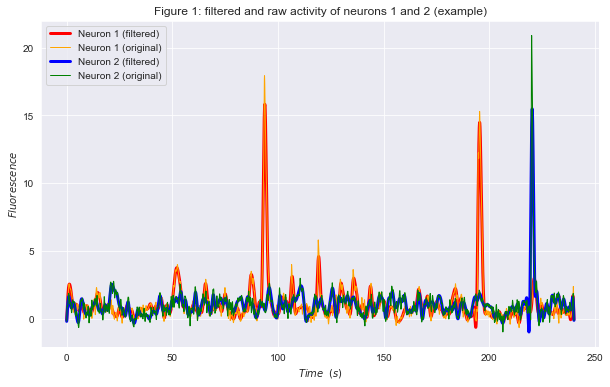

In [4]:
# Butterworth highpass filter:

filt_dFonF = [] # filtered data

def butter_highpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

for i in range(N):
    x = butter_highpass_filter(dFonF[i,:], 0.5, fs, 5) # order = 5, cutoff frequency = 0.5 Hz
    filt_dFonF.append(dFonF[i,:] - x)

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
sns.lineplot(x=t_im, y=filt_dFonF[0], color='red', linewidth=3, label='Neuron 1 (filtered)')
sns.lineplot(x=t_im, y=dFonF[0], color='orange', linewidth=1, label='Neuron 1 (original)')
sns.lineplot(x=t_im, y=filt_dFonF[1], color='blue', linewidth=3, label='Neuron 2 (filtered)')
sns.lineplot(x=t_im, y=dFonF[1], color='green', linewidth=1, label='Neuron 2 (original)')
plt.xlabel('$Time$  $(s)$')
plt.ylabel('$Fluorescence$')
plt.title('Figure 1: filtered and raw activity of neurons 1 and 2 (example)')
plt.legend()

<div style="text-align: justify"> As it is observable in Figure 1, some noise has been removed from the data. Later, an algorithm for discovering spikes was implemented. The conditions for spike recognition are the following: </div>

<div style="text-align: justify"> $1:$ The fluorescence value has to be higher than the sum of the root mean square of the signal and a constant multiplied to the signal's standard deviation: </div>

<div style="text-align: justify"> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ $x_{i}>RMS_{x} + k_{min}*\sigma_{x}$ </div>

<div style="text-align: justify"> $2:$ The fluorescence value has to be higher than the subtraction of the multiplication of a constant and the signal's standard deviation to the maximum value of the signal: </div>

<div style="text-align: justify"> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ $x_{i}>max(x) - k_{max}*\sigma_{x}$ </div>

<div style="text-align: justify"> Additionally, a waiting period of 50 positions (1.62 seconds) was added so that the same spike is not detected more than once. </div>

Text(0.5, 1.0, 'Figure 2: spike detection (example)')

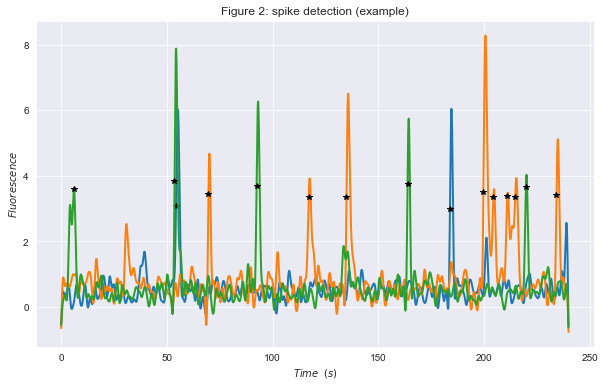

In [5]:
# Algorithm for discovering spikes:

def discover_spikes(x,t_im,k_min,k_max,wait):
    spike_end = True 
    position = [] 
    spike = [] 
    counter = 0
    
    for i in range(L): 
        if spike_end == False:
            counter += 1
            
        if x[i] >= (np.sqrt(np.mean(x**2)) + k_min*np.std(x)):
            if x[i] >= (max(x) - k_max*np.std(x)):
                if spike_end: 
                    position.append(i)
                    spike.append(x[i]) 
                    spike_end = False      
        elif counter >= wait: 
            spike_end = True 
            counter = 0
                
    return t_im[position], spike

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')

for i in range(40,43): 
    sns.lineplot(x=t_im, y=filt_dFonF[i], linewidth=2)
    X,Y = discover_spikes(filt_dFonF[i],t_im,2,5,50) 
    
    if X.size != 0:
        for j in range(len(X)): 
            plt.plot(X[j], Y[j], '*', color='black')

plt.xlabel('$Time$  $(s)$')
plt.ylabel('$Fluorescence$')
plt.title('Figure 2: spike detection (example)')

<div style="text-align: justify"> As Figure 2 shows, spikes are detected correctly. However, the objective is to detect the start of the action potentials. For that, the algorithm was slightly changed. The position of the spike is now assigned where one of these conditions is satisfied: </div>

<div style="text-align: justify"> $1:$ Going backwards from the previous spike position, where the fluorescence value is below the root mean square of the signal. </div>

<div style="text-align: justify"> $2:$ If two spikes happen close together (in the same lap, for example), the first condition would not be satisfied for the second spike. This is why the algorithm also detects when the slope turns steadily negative (due to the first action potential), and assigns the position to the minimum. </div>

Text(0.5, 1.0, 'Figure 3: spike detection (example)')

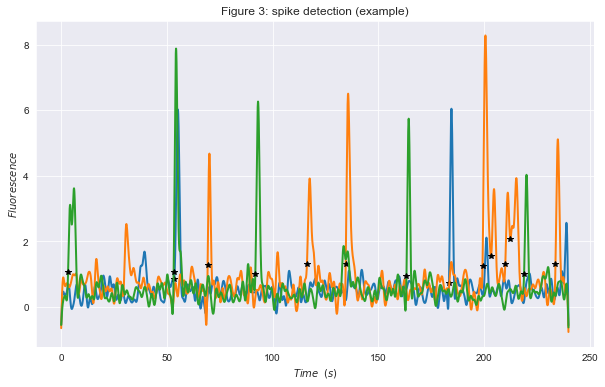

In [6]:
# Algorithm for discovering spikes:

def discover_spikes(x,t_im,k_min,k_max,wait):
    spike_end = True 
    position = [] 
    spike = [] 
    counter = 0
    
    for i in range(L): 
        if spike_end == False:
            counter += 1
            
        if x[i] >= (np.sqrt(np.mean(x**2)) + k_min*np.std(x)):
            if x[i] >= (max(x) - k_max*np.std(x)):
                if spike_end: 
                    r = 0     
                    while True:
                        if x[i-r] <= np.sqrt(np.mean(x**2)):
                            break
                        else: 
                            aux = []
                            for j in range(1,51):
                                if x[i-r] - x[i-r-j] < 0: aux.append(1)
                                else: aux.append(0)
                            if np.sum(aux) != 50: r += 1
                            else: break
                    position.append(i-r)
                    spike.append(x[i-r]) 
                    spike_end = False      
        elif counter >= wait: 
            spike_end = True 
            counter = 0
                
    return t_im[position], spike

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')

for i in range(40,43): 
    sns.lineplot(x=t_im, y=filt_dFonF[i], linewidth=2)
    X,Y = discover_spikes(filt_dFonF[i],t_im,2,5,50) 
    
    if X.size != 0:
        for j in range(len(X)): 
            plt.plot(X[j], Y[j], '*', color='black')

plt.xlabel('$Time$  $(s)$')
plt.ylabel('$Fluorescence$')
plt.title('Figure 3: spike detection (example)')

<div style="text-align: justify"> Now spikes are detected correctly. Following, the function to create event trains for the different time series is created. An event train is basically a binary function that gives 1 if a spike takes place and 0 if otherwise. Later, the event train for neuron 43, together with its fluorescence time series, was plotted in Figure 4: </div>

Text(0.5, 1.0, 'Figure 4: event train for neuron 43')

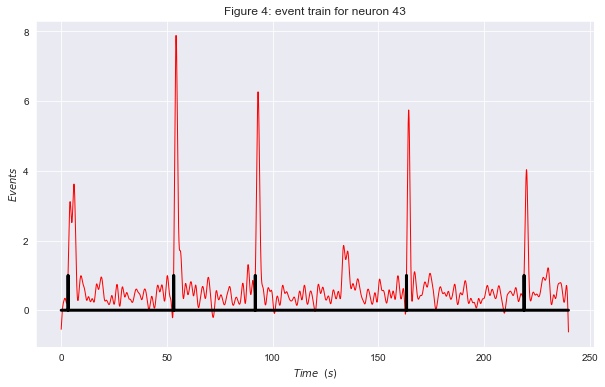

In [7]:
# Event trains:

def event_train(x):
    event = np.zeros_like(x)
    
    X,Y = discover_spikes(x,t_im,2,5,50)
        
    for i in range(L):
        for j in range(len(X)):
            if i == int(fs*X[j]):
                event[i] = 1
                
    return event
                
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')

sns.lineplot(x=t_im, y=filt_dFonF[42], color='red', linewidth=1)
find_event = event_train(filt_dFonF[42])
sns.lineplot(x=t_im, y=find_event, color='black', linewidth=3)

plt.xlabel('$Time$  $(s)$')
plt.ylabel('$Events$')
plt.title('Figure 4: event train for neuron 43')     

<div style="text-align: justify"> As it is visible, spikes are correctly detected in the event train. </div>

## Section 2

<div style="text-align: justify"> In section 2 the 'rastergram' of several event trains is shown. This is a plot in which the spikes are marked depending on the lap of occurence (y axis) and the angular position (x axis). With a rastergram it is easy to visualize when the firing of a neuron is correlated with a certain spatial position. To do all of these, it is first necessary to do a binning of the angular positions: </div>

In [260]:
# Binning of mouse angular positions:

bins = np.arange(0,360,0.5)
dig_mouse_theta = bins[np.searchsorted(bins,mouse_theta,side='left')-1]

<div style="text-align: justify"> Later, the different laps of the mouse in the track are detected. To do this, the code iteratively runs through the angular position of the mouse creating a vector ('find_lap') in which laps are associated with positions. In the program, it is important to take into account that the mouse can run backwards. </div>

In [56]:
# Identification of laps:

iterator = np.nditer(mouse_theta,flags=['multi_index'])

first_angle = iterator[0]
current_position = 0
lap = 1
find_lap = [lap]
flag = 0

while not iterator.finished:
    if (iterator[0] >= first_angle) and (flag == 0): pass
    elif (iterator[0] >= first_angle) and (flag == 1):
        find_lap.extend((lap*np.ones(iterator.multi_index[0] - current_position)).tolist())
        lap += 1
        current_position = iterator.multi_index[0]
        flag = 0
    elif abs(iterator[0] - previous_angle) > 100: flag = 1
    previous_angle = iterator[0]
    iterator.iternext()

find_lap.extend((lap*np.ones(np.size(mouse_theta) - current_position - 1)).tolist())
find_lap = np.array(find_lap)

<div style="text-align: justify"> Next, the rastergram function was created. It receives the desired neuron (and a colour for the plotting) and, apart from plotting its rastergram, it returns a vector containing the event train values with their corresponding binned spatial angles and laps. </div>

<div style="text-align: justify"> Additionally, I programmed a function to determine the selectivity of a neuron. This is, the tendency of a neuron to fire in specific angular positions. An important factor to take into account is that angles close to 360º and angles close to 0º have to be considered as similar. To do this, the angular data was converted into x and y coordinates of a circle of radius 1. Later, the selectivity was determined considering two factors: </div>

<div style="text-align: justify"> $1:$ The mean of the distances between points in the circle in which spikes took place: </div>

<div style="text-align: justify"> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ $d_{ij} = \sqrt{(x_{i} - x_{j})^2 + (y_{i} - y_{j})^2}$ </div>

<div style="text-align: justify"> $2:$ The number of times $N$ that neurons fire close together (from an angular perspective). This was used to take into account that different clusters could appear within the same neuron and that cells with more spikes should be favoured. </div>

<div style="text-align: justify"> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ $N+=1$ $\;\;\;$ $if$ $\;\;\;$ $d_{ij} < 0.3$ </div>

<div style="text-align: justify"> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ $selectivity = \frac{\overline{d}}{N+1}$ </div>

In [53]:
# Rastergram function and selectivity approximator:

def rastergram_function(neuron,color):
    find_event = event_train(filt_dFonF[neuron])
    x = []
    
    for i in range(L):
        x.append(np.array([find_event[i],find_lap[i],dig_mouse_theta[i][0]]))
        if find_event[i] == 1:
            plt.plot(dig_mouse_theta[i][0], find_lap[i], '*', color=color)
        
    return x

def selectivity_approximator(neuron):
    find_event = event_train(filt_dFonF[neuron])
    angles = []
    x = []
    y = []
    dist = []
    norm = 0
    selectivity_std = '-'
    
    for i in range(L):
        if find_event[i] == 1:
            angles.append(mouse_theta[i])
            x.append(mh.cos(mouse_theta[i]*mh.pi/180))
            y.append(mh.sin(mouse_theta[i]*mh.pi/180))
            
    for i in range(np.size(angles)):
        for j in range(i,np.size(angles)):
            if i != j:
                d = np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
                if d < 0.3:
                    norm += 1
                dist.append(d)
                
    if np.size(angles) > 1: selectivity_std = np.mean(dist) / (1 + norm) # possibility of multiple clusters
    else: selectivity_std = '-'
                
    return selectivity_std

In [528]:
selectivity_vector = []

for i in range(N):
    selectivity_vector.append(selectivity_approximator(i))

In [529]:
print(selectivity_vector)

[0.9356412414365982, '-', 0.6777988540594878, 0.6905499082067246, 1.9308582049290877, '-', 1.3576805844960453, 1.5489705480248175, '-', '-', '-', 0.4396989427908154, 0.6277924954106028, 1.1145147982057741, 0.38549747594407496, 0.3628544008982175, '-', '-', 0.2010635145406198, '-', '-', '-', '-', 1.3877612828954835, 1.2419839888165214, 0.7726111653309834, '-', '-', '-', 0.6647268004127996, '-', 1.466635538631981, '-', 1.681332692207484, '-', '-', '-', '-', 1.7857031784930226, '-', 1.397214246762506, 0.45436311063026297, 0.7250136139439596, 1.0067435913577896, 0.5077433770745453, '-', 0.13717314256793622, '-', '-', '-', 0.5527853367482926, 0.6636000529120866, '-', 0.04948368511558868, 1.5070544036141704, 0.17417919480314373, 1.1632307964463398, '-', '-', '-', '-', '-', 0.6400925970204805, 0.895118904776249, 0.41854504626679806, '-', 0.7033103062816142, 0.6880298200243368, '-', 0.44593445083204414, '-', '-', 0.6943169777274318, 0.2692659513830762, '-']


<div style="text-align: justify"> As it is intuitive, the selectivity can only be calculated if the number of spikes is greater than 1. If this is not the case, the selectivity function shows '-'. In the vector, it is visible that one of the best (lowest) results is given by neuron 56 (0.174). This means that this neuron is highly selective: it fires in similar angular positions. An example of an averagely selective cell is neuron 25 (1.242). Low selectivity is found in neuron 55 (1.507). The rastergrams of these cells are shown below (Figure 5): </div>

Text(0.5, 1.0, 'Figure 5: rastergram for neurons 56 (red), 25 (blue) and 55 (green)')

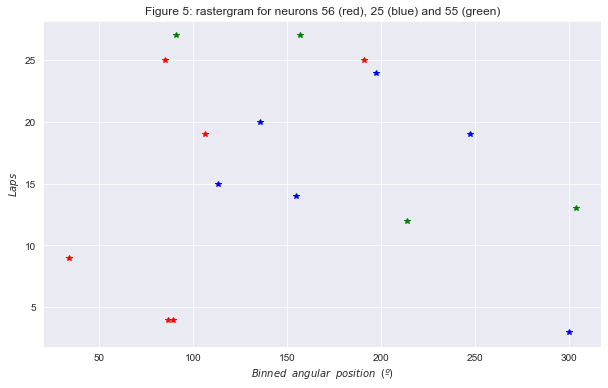

In [262]:
# Example of high selectivity: neuron 56
# Example of medium selectivity: neuron 25
# Example of high selectivity: neuron 55

# Rastergram for neurons 56 (red), 25 (blue) and 55 (green)

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')

x = rastergram_function(55,'red')
y = rastergram_function(24,'blue')
z = rastergram_function(54,'green')
            
plt.xlabel('$Binned$  $angular$  $position$  $(º)$')
plt.ylabel('$Laps$')
plt.title('Figure 5: rastergram for neurons 56 (red), 25 (blue) and 55 (green)')  

<div style="text-align: justify"> In Figure 5 it is clear that the selectivity approximator correctly detects selective neurons. Note that the red dots, which correspond to the highly selective neuron, tend to be around 70-80º. However, due to the lack of a greater database, results cannot be conclusive. </div>

In [533]:
highly_selective_neurons = []

for i in range(N):
    if selectivity_vector[i] != '-':
        if selectivity_vector[i] < 0.2:
            highly_selective_neurons.append(i)
            
print('Hihgly selective neurons: ', highly_selective_neurons)

Hihgly selective neurons:  [46, 53, 55]


<div style="text-align: justify"> According to the algorithm, the most selective neurons are cells 47, 54 and 56. Their respective rastergrams are plotted below: </div>

Text(0.5, 1.0, 'Figure 6: rastergram for neurons 47 (red), 54 (blue) and 56 (green)')

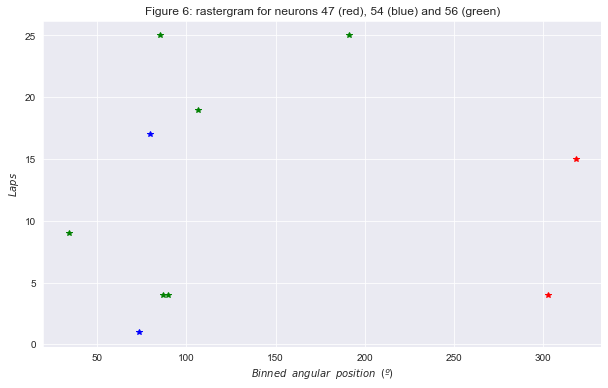

In [535]:
# Rastergram for neurons 47 (red), 54 (blue) and 56 (green)

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')

a = rastergram_function(46,'red')
b = rastergram_function(53,'blue')
c = rastergram_function(55,'green')

plt.xlabel('$Binned$  $angular$  $position$  $(º)$')
plt.ylabel('$Laps$')
plt.title('Figure 6: rastergram for neurons 47 (red), 54 (blue) and 56 (green)')  

<div style="text-align: justify"> Neurons 47 and 54 only have two spikes. However, neuron 56 has 6 spikes, 4 of them being highly clustered around 100º. It is, therefore, possible to say that neuron 56 could be correlated with that position. </div>

## Section 3

<div style="text-align: justify"> In section 3, the mutual information between the event train (binary response) and the spatial angle was calculated. The mutual information is a measurement of the mutual dependence between two variables, and it represents the amount of "information" that we can obtain of one variable by observing the other. To calculate it, two different methods were applied: </div>

<div style="text-align: justify"> $1:$ The mutual information ($I(X,Y)$) is the sum of the marginal entropies ($H(X)$: marginal entropy of the spatial angle, $H(Y)$: marginal entropy of the binary response) minus the joint entropy ($H(X,Y)$). The data was grouped in 20 bins. </div>

<div style="text-align: justify"> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ $I(X,Y) = H(X) + H(Y) - H(X,Y)$ </div>

<div style="text-align: justify"> $\;\;\;\;\;\;\;\;\;\;\;$ $H(X) = - \sum_{x}P(X)\;log\;P(X)$ $\;\;\;\;\;\;\;\;\;\;\;$ $H(Y) = - \sum_{y}P(Y)\;log\;P(Y)$ $\;\;\;\;\;\;\;\;\;\;\;$ $H(X,Y) = - \sum_{x}\sum_{y}P(X,Y)\;log\;P(X,Y)$ </div>

<div style="text-align: justify"> Being $P(X)$ the probability of the mouse being in one angle bin, $P(Y)$ the probability of an event (spike) and $P(X,Y)$ the probability of having an event and being in one specific angle bin. </div>

In [8]:
# Mutual information (method 1): I = Hs + Hr - Hsr

def entropy(px):
    idx = px > 0
    H = -np.sum(px[idx]*np.log2(px[idx]))
    return H

n = 20
I_1 = []
H_x = []

for i in range(N):
    find_event = event_train(filt_dFonF[i])
    cs,bins = np.histogram(find_event,n)
    cr,bins = np.histogram(mouse_theta[:,0],n)
    csr,bins_s,bins_r = np.histogram2d(find_event,mouse_theta[:,0],n)
    Ps = cs/cs.sum()
    Pr = cr/cr.sum()
    Psr = csr/csr.sum()
    Hs = entropy(Ps)
    Hr = entropy(Pr)
    H_x.append(Hr)
    Hsr = entropy(Psr)
    I_1.append(Hs + Hr - Hsr)

<div style="text-align: justify"> $2:$ The mutual information can also be calculated directly with probabilities, following the formula shown below: </div>

<div style="text-align: justify"> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ $I(X,Y) = \sum_{x}\sum_{y}P(X,Y)\;log\;\frac{P(X,Y)}{P(X)\;P(Y)}$ </div>

<div style="text-align: justify"> To solve this, several probabilities had to be calculated: $P(X)$, $P(Y)$, $P(X,Y)$, $P(\bar{Y})$ and $P(X,\bar{Y})$. However, a few simplifications can be done. Events are rare, happening once every few thousands of recordings. Due to this, we can assume that $P(\bar{Y})$ ≈ $1$ and $P(Y)$ ≈ $0$. Following: </div>

<div style="text-align: justify"> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ $P(X/\bar{Y}) = \frac{P(X)\;-\;P(Y)P(X/Y)}{P(\bar{Y})}$ ≈ $P(X)$ </div>

<div style="text-align: justify"> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ $P(X,\bar{Y}) = P(\bar{Y})P(X/\bar{Y})$ ≈ $P(X)$ </div>

<div style="text-align: justify"> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ $log\;\frac{P(X,\bar{Y})}{P(X)\;P(\bar{Y})}$ ≈ $log\;1$ $=$ $0$ </div>

<div style="text-align: justify"> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ $I(X,Y)$ ≈ $\sum_{x}P(X,Y)\;log\;\frac{P(X,Y)}{P(X)\;P(Y)}$ </div>

In [9]:
# Binning of mouse angle positions:

bins = np.arange(0,360,360/20)
dig_mouse_theta = bins[np.searchsorted(bins,mouse_theta,side='left')-1]

In [10]:
# Probability of being in one bin:

x = np.zeros(np.size(bins))
p_x = np.zeros(np.size(bins))

for i in range(np.size(bins)):
    for j in range(L):
        if i != 19:
            if mouse_theta[j] >= bins[i] and mouse_theta[j] < bins[i+1]: x[i] += 1
        else:
            if mouse_theta[j] >= bins[i]: x[i] += 1
                
    p_x[i] = x[i]/L
    
# Rest of required probabilities:

x = np.zeros((N,np.size(bins)))
p_y = np.zeros(N)
p_x_given_y = np.zeros((N,np.size(bins)))
p_x_and_y = np.zeros((N,np.size(bins)))

# p_x_given_not_y = np.zeros((N,np.size(bins)))
# p_x_given_not_y ≈ p_x

# p_x_and_not_y = np.zeros((N,np.size(bins)))
# p_x_and_not_y ≈ p_x

for i in range(N):
    find_event = event_train(filt_dFonF[i])
    for j in range(L):
        if find_event[j] == 1:
            for k in range(np.size(bins)):
                if dig_mouse_theta[j-1] == bins[k]: x[i,k] += 1
    
    p_y[i] = np.sum(find_event)/np.size(find_event)
    p_x_given_y[i] = x[i]/np.sum(find_event)
    p_x_and_y[i] = p_y[i]*p_x_given_y[i]
    # p_x_given_not_y[i] = (p_x - p_y[i]*p_x_given_y[i])/(1 - p_y[i])
    # p_x_and_not_y[i] = (1 - p_y[i])*p_x_given_not_y[i]

In [11]:
# Mutual information (method 2): I = sum_x{sum_y{Pxy*log2(Pxy/(Px*Py))}}

# b ≈ 0

I_2 = np.zeros(N)

for i in range(N):
    for j in range(np.size(bins)):
        if p_x_and_y[i,j] > 0 and p_x[j] > 0 and p_y[i] > 0:
            a = p_x_and_y[i,j]*np.log2(p_x_and_y[i,j]/(p_x[j]*p_y[i]))
            # b = p_x_and_not_y[i,j]*np.log2(p_x_and_not_y[i,j]/(p_x[j]*p_not_y[i]))
            I_2[i] += a # + b


<div style="text-align: justify"> Below, the mutual information (calculated by both methods and the average) for the neurons with different selectivities plotted in section 2 (cells 56, 25 and 55) is displayed: </div>

In [12]:
# The results of mutual information for neurons 56, 25 and 55:

avg_56 = (I_1[55]+I_2[55])/2
avg_25 = (I_1[24]+I_2[24])/2
avg_55 = (I_1[54]+I_2[54])/2

print('Mutual information of neuron 56: ', round(I_1[55],4), ' and ', round(I_2[55],4), '-> average = ', round(avg_56,4))
print('Mutual information of neuron 25: ', round(I_1[24],4), ' and ', round(I_2[24],4), '-> average = ', round(avg_25,4))
print('Mutual information of neuron 55: ', round(I_1[54],4), ' and ', round(I_2[54],4), '-> average = ', round(avg_55,4))

Mutual information of neuron 56:  0.0014  and  0.0014 -> average =  0.0014
Mutual information of neuron 25:  0.0012  and  0.0012 -> average =  0.0012
Mutual information of neuron 55:  0.0011  and  0.0009 -> average =  0.001


<div style="text-align: justify"> The highly selective neuron (56) has the highest value of mutual information (0.0014), while cell 55, chosen before as the low selective neuron, has the lowest value of the three. The results are, therefore, coherent. However, the dataset is too small to draw definitive conclusions and the mutual information values are all extremely low. More data should be recorded to determine if there is a relationship between spatial angle and action potentials. </div>

## Section 4

<div style="text-align: justify"> Later, in section 4, the mutual information / marginal angular entropy ratio for the cell with the highest mutual information value was calculated: </div>

In [294]:
# Best value of mutual information and its 'spatial location variable' entropy:

x = 0
best = 0

for i in range(N):
    if I_1[i] > x: 
        x = I_1[i]
        best = i

print('The highest value of mutual information correspond to neuron:', best+1)
print('Mutual information: I =', round(I_1[best],4))
print('Uncertainty (entropy) of the spatial location variable: H_x =', round(H_x[best],4))
print('Mutual information - entropy ratio: I/H_x =', round(I_1[best]/H_x[best],4))

The highest value of mutual information correspond to neuron: 65
Mutual information: I = 0.0022
Uncertainty (entropy) of the spatial location variable: H_x = 4.1312
Mutual information - entropy ratio: I/H_x = 0.0005


<div style="text-align: justify"> The ratio ($\frac{I(X,Y)}{H(X)}$) is ≈ $0.0005$. This means that the mutual information is too low (even for the best cell) to conclude that there is a relationship between the neuronal spikes and the spatial position. As stated above, more information should be recorded to obtain precise conclusions. </div>

## Section 5

<div style="text-align: justify"> In section 5 the mutual information density distributions for all neurons (and for both methods) were plotted in Figure 7: </div>

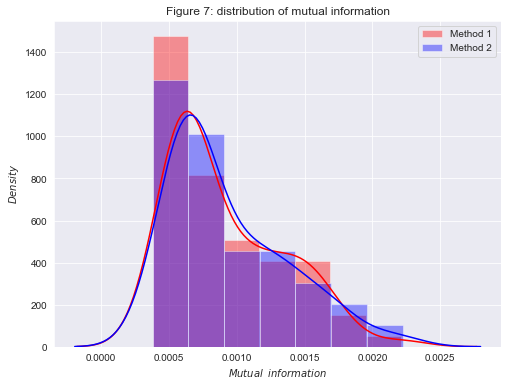

In [33]:
plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.distplot(I_1, color='red', label='Method 1')
sns.distplot(I_2, color='blue', label='Method 2')
plt.xlabel('$Mutual$  $information$')
plt.ylabel('$Density$')
plt.title('Figure 7: distribution of mutual information')
plt.legend()

<div style="text-align: justify"> As it is visible, the distribution is far from normal for both methods. In fact, both distributions are similar, suggesting that both methods give resembling results. High (in relative terms) values of mutual information are much less frequent than lower ones. </div>

<div style="text-align: justify"> Lastly, the mutual information values for each neuron (and for both methods) were plotted (Figure 8): </div>

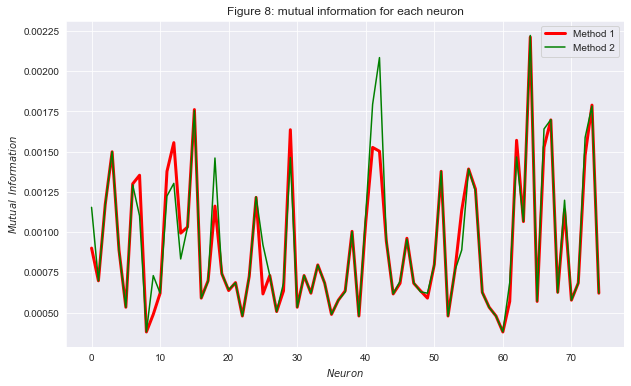

In [13]:
# Plot of the mutual information (both methods) for each neuron:

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
plt.plot(I_1, color='red', label='Method 1', linewidth=3)
plt.plot(I_2, color='green', label='Method 2', linewidth=1.5)
plt.xlabel('$Neuron$')
plt.ylabel('$Mutual$  $Information$')
plt.title('Figure 8: mutual information for each neuron')
plt.legend()

<div style="text-align: justify"> First of all, it is clear that both methods give similar results. This demonstrates that the simplifications were consistent and that the mutual information was calculated correctly. Given that no value is zero, it is possible to say that all neurons spike at least once. It is also noticeable how the highest values of mutual information are given by neurons 43 and 65. However, all values are too low: more data is necessary. </div>